In [558]:
from perfetto.trace_processor import TraceProcessor, TraceProcessorConfig
import matplotlib.pyplot as plt


In [566]:
config = TraceProcessorConfig(verbose=True,bin_path='./trace_processor')

tp = TraceProcessor(trace='./results/pixel/trace-three-0-8',config=config)
qr_it = tp.query('select ts, counter_track.name, value  from counter left join counter_track where counter_track.id=counter.track_id')
qr_df = qr_it.as_pandas_dataframe()
print(qr_df.head())

[858.139]             httpd.cc:99 [HTTP] Starting RPC server on localhost:51051
[858.139]            httpd.cc:104 [HTTP] This server can be used by reloading https://ui.perfetto.dev and clicking on YES on the "Trace Processor native acceleration" dialog or through the Python API (see https://perfetto.dev/docs/analysis/trace-processor#python-api).


                 ts               name          value
0  1558600176656161    batt.charge_uah      4576000.0
1  1558600176656161  batt.capacity_pct          100.0
2  1558600176656161    batt.current_ua        -1562.0
3  1558600179000000    power.rails.tpu   2363761053.0
4  1558600179000000  power.rails.modem  99418079947.0


[859.091]       http_server.cc:83 [HTTP] New connection
[859.092]      http_server.cc:231 [HTTP] GET /status [body=0B, origin=""]
[859.092]       http_server.cc:90 [HTTP] Client disconnected
[859.094]       http_server.cc:83 [HTTP] New connection
[859.094]      http_server.cc:231 [HTTP] POST /parse [body=104589B, origin=""]
[859.099]      http_server.cc:231 [HTTP] GET /notify_eof [body=0B, origin=""]
Loading trace 0.10 MB (0.0 MB/s)
[859.109]      http_server.cc:231 [HTTP] POST /query [body=116B, origin=""]


In [567]:
power_df = qr_df[qr_df['name'].str[:5] == 'power']
power_df = power_df.drop_duplicates()
print(power_df['name'].value_counts())

name
power.rails.tpu                 240
power.rails.modem               240
power.rails.radio.frontend      240
power.rails.cpu.big             240
power.rails.cpu.mid             240
power.rails.cpu.little          240
power.rails.system.fabric       240
power.rails.memory.interface    240
power.rails.wifi.bt             240
power.rails.aoc.memory          240
power.rails.aoc.logic           240
power.rails.ddr.a               240
power.rails.ddr.b               240
power.rails.ddr.c               240
power.rails.gpu                 240
power.rails.display             240
Name: count, dtype: int64


['power.rails.aoc.logic', 'power.rails.aoc.memory', 'power.rails.cpu.big', 'power.rails.cpu.little', 'power.rails.cpu.mid', 'power.rails.ddr.a', 'power.rails.ddr.b', 'power.rails.ddr.c', 'power.rails.display', 'power.rails.gpu', 'power.rails.memory.interface', 'power.rails.modem', 'power.rails.radio.frontend', 'power.rails.system.fabric', 'power.rails.tpu', 'power.rails.wifi.bt']


/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/958261383.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] = diffs / time_diffs * 1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/958261383.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] = diffs / time_diffs * 1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/958261383.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

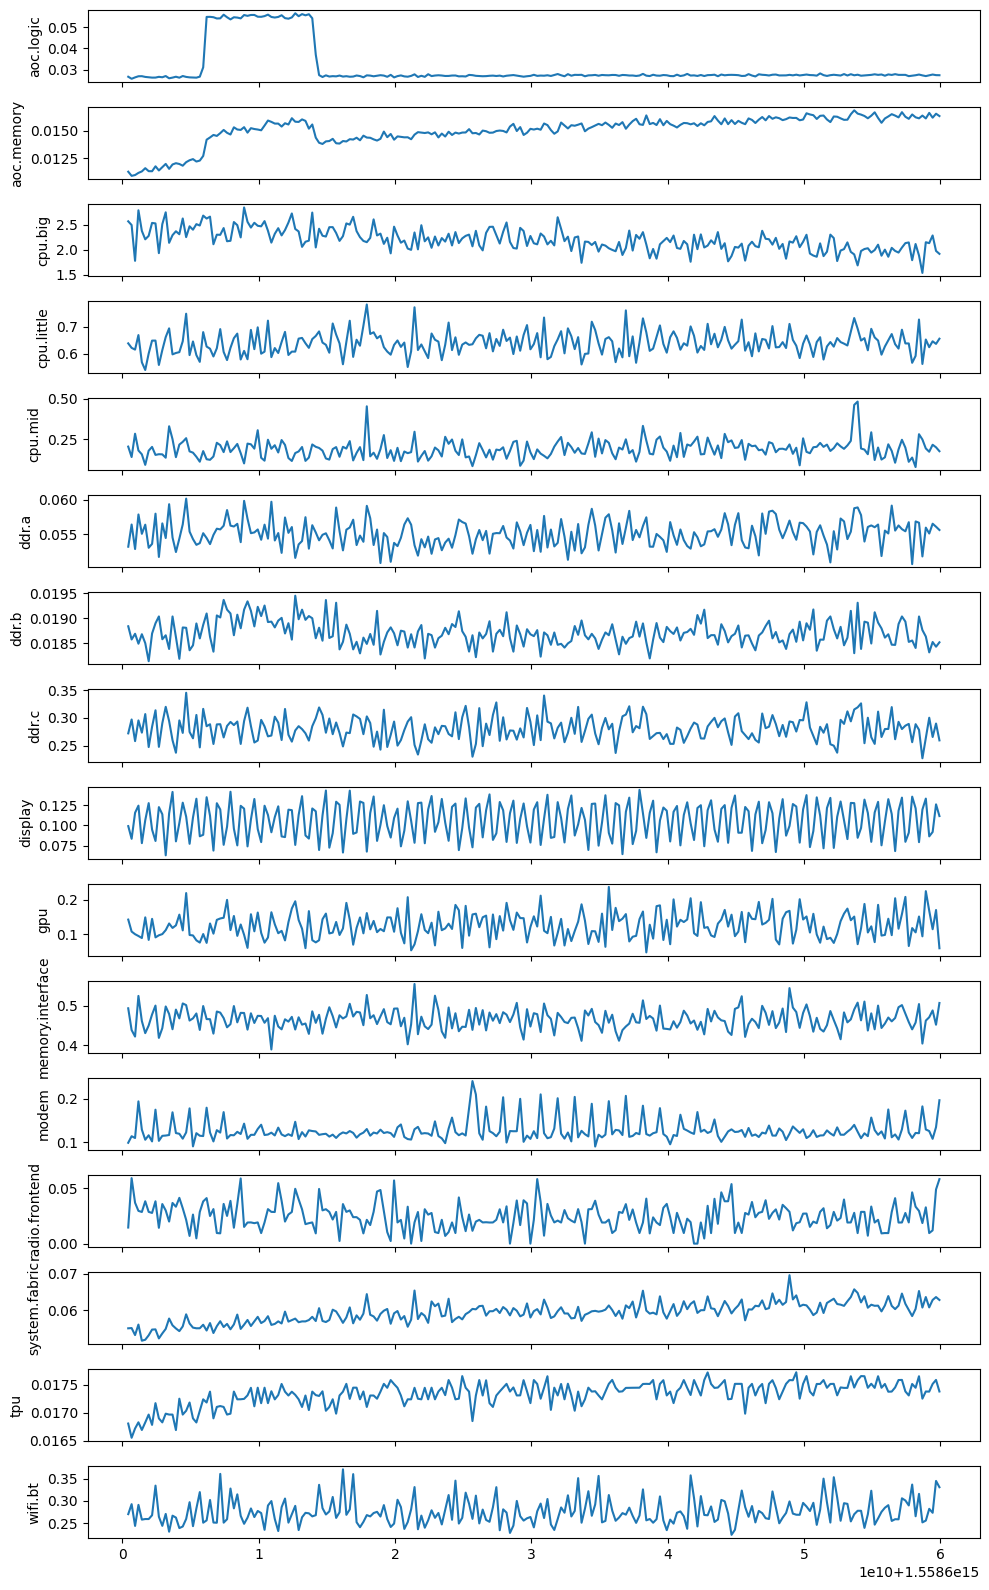

In [568]:


unique_names = sorted(power_df['name'].unique())
print(unique_names)

num_rows = len(unique_names)
num_cols = 1


fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1*num_rows), sharex=True)

for i, name in enumerate(unique_names):
    data = power_df[power_df['name'] == name]
    diffs = data['value'].diff()
    time_diffs = data['ts'].diff()
    data['ratio'] = diffs / time_diffs * 1000
    data = data.dropna()
    axes[i].plot(data['ts'], data['ratio'],label=name)
    axes[i].set_ylabel(name[12:])



plt.tight_layout()

plt.show()


In [569]:
total_mean_ratio = 0
name_mean_ratio = {}
for i, name in enumerate(unique_names):
    data = power_df[power_df['name'] == name]
    diffs = data['value'].diff()
    time_diffs = data['ts'].diff()
    data['ratio'] =  diffs / time_diffs*1000
    data = data.dropna()
    mean_ratio = data['ratio'].mean()
    name_mean_ratio[name] = mean_ratio
    total_mean_ratio += mean_ratio

print("sum:", total_mean_ratio)
for name, mean_ratio in name_mean_ratio.items():
    ratio_percentage = (mean_ratio / total_mean_ratio) * 100
    print(f"{name} :{mean_ratio}, {ratio_percentage:.2f}%")


sum: 4.634675690637051
power.rails.aoc.logic :0.030905556559312798, 0.67%
power.rails.aoc.memory :0.015082243817304587, 0.33%
power.rails.cpu.big :2.2004071136959347, 47.48%
power.rails.cpu.little :0.6402450562304047, 13.81%
power.rails.cpu.mid :0.19126738347272054, 4.13%
power.rails.ddr.a :0.055099443553104865, 1.19%
power.rails.ddr.b :0.018708631223014163, 0.40%
power.rails.ddr.c :0.2809971502483359, 6.06%
power.rails.display :0.10624058422326997, 2.29%
power.rails.gpu :0.12644226159415492, 2.73%
power.rails.memory.interface :0.46553451780371335, 10.04%
power.rails.modem :0.12676150459943214, 2.74%
power.rails.radio.frontend :0.02456629876520751, 0.53%
power.rails.system.fabric :0.0593270854913161, 1.28%
power.rails.tpu :0.01733338336508877, 0.37%
power.rails.wifi.bt :0.27575747599473693, 5.95%


/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1295074675.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] =  diffs / time_diffs*1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1295074675.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] =  diffs / time_diffs*1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1295074675.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
